# Prédiction noeud par noeud
On fait ici un modèle de prédiction noeud par noeud.
On utilise le 12 features de chaque noeud  + les features et la value du parent comme input du modèle.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir("/content/drive/MyDrive/Colab Notebooks")
print(f"Répertoire de travail: {os.getcwd()}")

Répertoire de travail: /content/drive/MyDrive/Colab Notebooks


In [ ]:
# simple logger to track progress during training (from TP1)
class Logger:
  def __init__(self):
    self.losses_train = []
    self.losses_val = []
    self.differences_train = []
    self.differences_val = []
    self.std_train = []
    self.std_val = []

  def log(self, loss_train=0, difference_train=0, standard_train=0, loss_val=0, difference_val=0, standard_val=0):
    self.losses_train.append(loss_train)
    self.differences_train.append(difference_train)
    self.std_train.append(standard_train)
    self.losses_val.append(loss_val)
    self.differences_val.append(difference_val)
    self.std_val.append(standard_val)

  def plot_loss(self, train=True, val=True):
    if not train and not val:
      raise ValueError("Cannot plot loss because train and val")
    plt.figure()
    if train:
      plt.plot(self.losses_train, label="Train")
    if val:
      plt.plot(self.losses_val, label="Val")
    plt.legend(loc='best')
    plt.xlabel("Epoch")
    plt.title("CrossEntropy Loss")

  def plot_difference(self, train=True, val=True):
    if not train and not val:
      raise ValueError("Cannot plot accuracy because train and val")
    plt.figure()
    if train:
      plt.plot(self.differences_train, label="Train")
    if val:
      plt.plot(self.differences_val, label="Val")
    plt.legend(loc='best')
    plt.xlabel("Epoch")
    plt.title("Mean absolute difference")

  def plot_standard_deviation(self, train=True, val=True):
    if not train and not val:
      raise ValueError("Cannot plot accuracy because train and val")
    plt.figure()
    if train:
      plt.plot(self.std_train, label="Train")
    if val:
      plt.plot(self.std_val, label="Val")
    plt.legend(loc='best')
    plt.xlabel("Epoch")
    plt.title("Standard deviation")
  
  def print_last():
    print(f"Epoch {len(self.losses_train):2d}, \
                  Train:loss={self.losses_train[-1]:.3f}, accuracy={self.accuracies_train[-1]*100:.1f}%, difference={self.differences_train[-1]:.2e} \
                  Val: loss={self.losses_val[-1]:.3f}, accuracy={self.accuracies_val[-1]*100:.1f}%, difference={self.differences_val[-1]:.2e}", flush=True)
    


In [ ]:
"""
Objet regroupant les caractéristiques d'un noeud du Branch and Bound.
Contient les noeuds fils.
"""

class BBNode:
    def __init__(self, bb_name: str, node_number: int, features: dict, value: float):
        self.bb_name = bb_name
        self.node_number = node_number
        self.features = features
        self.value = value

        self.parent_node = None
        self.children_nodes = []

    def add_child(self, child_node):
        self.children_nodes.append(child_node)
        child_node.parent_node = self

    def __str__(self):
        desc = ""
        parent_id = 'None'
        if self.parent_node is None:
            desc += self.bb_name + ':\n'
        else:
            parent_id = self.parent_node.node_number

        desc += f'[{parent_id}] -> [{self.node_number}]: {self.value}\n'
        desc += ''.join([str(child) for child in self.children_nodes])
        return desc

In [ ]:
import pandas as pd

def read_all_dfs(path):
    dfs = {}
    for file in os.listdir(path):
        dfs[file] = pd.read_csv(os.path.join(path, file))
    return dfs

def build_bbtree(df, filename):
    """
    Build the Branch and Bound tree for the given df.
    """
    feature_name = [f for f in df.columns
                    if f not in {'node_number', 'parent_node_number', 'value'}]
    
    nodes = dict()  # node_id -> BBNode
    parent_map = dict()  # node_id -> parent_id
        
    # Build all BBNodes
    for i in range(len(df)):
        node_id = df.loc[i, 'node_number']
        parent_id = df.loc[i, 'parent_node_number']
        value = df.loc[i, 'value']
        features = dict(df.loc[i, feature_name])
        node = BBNode(filename, node_id, features, value)

        nodes[node_id] = node
        parent_map[node_id] = parent_id

    # Link BBNodes to their parent
    for node_id, node in nodes.items():
        parent_id = parent_map[node_id]
        if parent_id in nodes:
            parent_node = nodes[parent_id]
            parent_node.add_child(node)

    return nodes

def keep_parent_nodes(nodes):
    """
    Filter all nodes in the dictionary, to keep only
    the nodes that are parent to some other nodes.
    """
    parents_id = set(n_id for n_id, n in nodes.items()
                     if n.children_nodes)
    return {p_id: parent for p_id, parent in nodes.items()
            if p_id in parents_id}

def get_trees(path):
    dfs = read_all_dfs(path)
    trees = {f: build_bbtree(df, f) for f, df in dfs.items()}
    trees = {f: keep_parent_nodes(nodes) for f, nodes in trees.items()}
    return trees

## TODO
* Mélanger l'ordre des nodes pendant le training

In [ ]:
import pylab
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [ ]:
%%time

path = 'data/second_labels/normalized/train/'
trees = get_trees(path)
total_len = sum([len(t) for t in trees.values()])
print(f'Number of parents: {total_len:,}')

Number of parents: 27,873
CPU times: user 1min 28s, sys: 1.63 s, total: 1min 30s
Wall time: 1min 29s


In [ ]:
from sklearn.model_selection import train_test_split

def tree_to_dataset(tree, number_of_childs=5):
    """
    Créer une ligne par noeud et ajoute 
    les features et la value du parent associé. 
    """
    rows, values = [], []
    
    for parent_node in tree.values():
        feature_names = sorted(parent_node.features.keys())
        parent_features = np.array([parent_node.features[f] for f in feature_names])
        parent_value = np.array([parent_node.value])
        parent_row = np.concatenate((parent_features,parent_value), axis=0)
        final_row = []
        final_values = []
        
        if len(parent_node.children_nodes) != number_of_childs:
            continue  # Invalid parent
        
        for child in parent_node.children_nodes:
            child_row = np.array([child.features[f] for f in feature_names])
            child_row = np.concatenate((child_row, parent_row),axis=0)
            final_row.append(child_row)
            final_values.append(child.value)
        
        rows.append(np.array(final_row))
        values.append(np.array(final_values))
        
    return np.array(rows), np.array(values)

def build_dataset(trees):
    rows = []
    values = []
    for tree in trees.values():
        rows_t, values_t = tree_to_dataset(tree)
        if rows_t.shape[0] != 0:
            rows.append(rows_t)
            values.append(values_t)
    
    rows = np.concatenate(rows, axis=0)
    rows = np.concatenate(rows, axis=0)
    values = np.concatenate(values, axis=0)
    values = np.concatenate(values, axis=0)
    
    return rows, values

rows, values = build_dataset(trees)
print(f'Number of rows: {rows.shape[0]: ,}')
print(f'Number of features: {rows.shape[1]}\n')

X_train, X_test, y_train, y_test = train_test_split(rows, values, test_size=0.2)
print(f'Number of training examples: {len(X_train): ,}')
print(f'Number of validation examples: {len(X_test): ,}')

Number of rows:  136,855
Number of features: 25

Number of training examples:  109,484
Number of validation examples:  27,371


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
!pip install torchinfo
from torchinfo import summary

In [ ]:
class Dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, rows, values):
        self.rows = torch.FloatTensor(rows)
        self.values = torch.FloatTensor(values)
        
    def __len__(self):
        return len(self.rows)

    def __getitem__(self, index):
        return rows[index], values[index]

train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

In [ ]:
torch.set_default_dtype(torch.double)

def eval_dataset(model, criterion, dataloader):
    model.eval()
    losses = []
    diff = []
    
    cuda = torch.cuda.is_available()
    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    
    for rows, values in dataloader:
        if cuda:
            rows = rows.cuda()
            values = values.cuda()

        output = model(rows).squeeze()

        loss = criterion(output, values).item()
        diff.extend(abs(output-values).tolist())
        losses.append(loss)
    return np.mean(losses), np.mean(diff), np.std(diff)

def train(model, data_train, data_val,
          criterion, optimizer, epochs,
          print_each=1):
  
    train_loss, train_diff, train_std = [], [], []
    val_loss, val_diff, val_std = [], [], []
    best_diff = 100
    best_std = 100
    best_model = None
    logger = Logger()
    
    cuda = torch.cuda.is_available()
    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    
    for e in range(1, epochs+1):
        model.train()
        for rows, values in data_train:
            if cuda:
                rows = rows.cuda()
                values = values.cuda()

            pred = model(rows).squeeze()
            loss = criterion(pred, values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train, diff_train, std_train = eval_dataset(model, criterion, data_train)
        train_loss.append(loss_train)
        train_diff.append(diff_train)
        train_std.append(std_train)
        
        loss_val, diff_val, std_val = eval_dataset(model, criterion, data_val)
        val_loss.append(loss_val)
        val_diff.append(diff_val)
        val_std.append(std_val)

        if diff_val < best_diff: # On garde le meilleur modèle obtenu jusqu'à maintenant 
            best_diff = diff_val
            best_std = std_val
            best_model = model

        logger.log(loss_train, diff_train, std_train, loss_val, diff_val, std_val)
        
        if e % print_each == 0:
            print(f'Epoch {e}')
            print(f'Train loss: {train_loss[-1]:.3f} \tVal loss: {val_loss[-1]:.3f}')
            print(f'Train difference: {train_diff[-1]:.2e} \tVal difference: {val_diff[-1]:.2e}')
            print(f'Train standard deviation: {train_std[-1]:.2e} \tVal standard deviation: {val_std[-1]:.2e}\n')
    
    return best_model, logger, best_diff, best_std

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, n_layers, n_hidden):
        super(MLP, self).__init__()
        
        self.project = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.SELU(),
        )
        
        self.resnet = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_hidden, n_hidden // 2),
                nn.BatchNorm1d(n_hidden // 2),
                nn.SELU(),
                nn.Linear(n_hidden // 2, n_hidden),
                nn.BatchNorm1d(n_hidden),
                nn.SELU(),
            )
            for _ in range(n_layers)
        ])
        
        self.output = nn.Linear(n_hidden, 1)

        
    def forward(self, x):
        x = self.project(x)
        for layer in self.resnet:
            x = x + layer(x)
        x = self.output(x)
        return torch.sigmoid(x)

In [ ]:
batch_size = 200
input_size = X_train.shape[1]
lr = 1e-5
epochs = 100
criterion = nn.BCELoss()
print_each = 10

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Expériences

## Changement des hyperparamètres suivants : nombre de couches et nombre de neurones

### Modèle 1

In [ ]:
n_layers = 5
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)
summary(model, (input_size,25,),dtypes=(torch.double,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [25, 400]                 --
|    └─Linear: 2-1                       [25, 400]                 10,400
|    └─SELU: 2-2                         [25, 400]                 --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-3                   [25, 400]                 --
|    |    └─Linear: 3-1                  [25, 200]                 80,200
|    |    └─BatchNorm1d: 3-2             [25, 200]                 400
|    |    └─SELU: 3-3                    [25, 200]                 --
|    |    └─Linear: 3-4                  [25, 400]                 80,400
|    |    └─BatchNorm1d: 3-5             [25, 400]                 800
|    |    └─SELU: 3-6                    [25, 400]                 --
|    └─Sequential: 2-4                   [25, 400]                 --
|    |    └─Linear: 3-7                  [25, 200]                 80,2

Epoch 10
Train loss: 0.337 	Val loss: 0.362
Train difference: 2.14e-02 	Val difference: 3.64e-02
Train standard deviation: 3.37e-02 	Val standard deviation: 5.50e-02

Epoch 20
Train loss: 0.336 	Val loss: 0.361
Train difference: 1.97e-02 	Val difference: 3.46e-02
Train standard deviation: 3.19e-02 	Val standard deviation: 5.25e-02

Epoch 30
Train loss: 0.336 	Val loss: 0.359
Train difference: 1.91e-02 	Val difference: 3.31e-02
Train standard deviation: 2.98e-02 	Val standard deviation: 4.83e-02

Epoch 40
Train loss: 0.335 	Val loss: 0.358
Train difference: 1.88e-02 	Val difference: 3.18e-02
Train standard deviation: 2.84e-02 	Val standard deviation: 4.55e-02

Epoch 50
Train loss: 0.335 	Val loss: 0.357
Train difference: 1.76e-02 	Val difference: 3.02e-02
Train standard deviation: 2.69e-02 	Val standard deviation: 4.31e-02

Epoch 60
Train loss: 0.335 	Val loss: 0.356
Train difference: 1.70e-02 	Val difference: 2.86e-02
Train standard deviation: 2.53e-02 	Val standard deviation: 3.99e-02

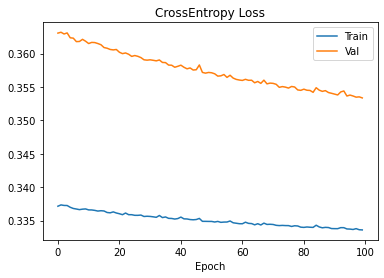

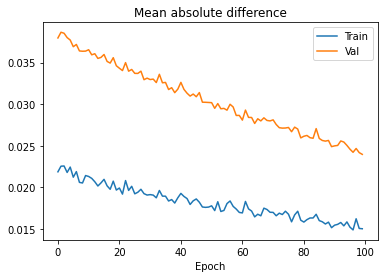

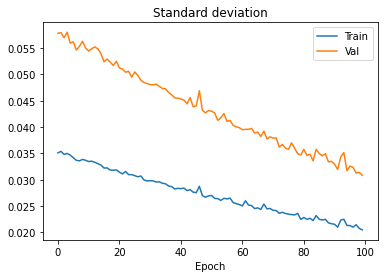

In [ ]:
%%time
optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

### Modèle 2

Epoch 10
Train loss: 0.334 	Val loss: 0.354
Train difference: 1.67e-02 	Val difference: 2.50e-02
Train standard deviation: 2.20e-02 	Val standard deviation: 3.20e-02

Epoch 20
Train loss: 0.334 	Val loss: 0.354
Train difference: 1.61e-02 	Val difference: 2.46e-02
Train standard deviation: 2.11e-02 	Val standard deviation: 3.14e-02

Epoch 30
Train loss: 0.334 	Val loss: 0.352
Train difference: 1.59e-02 	Val difference: 2.28e-02
Train standard deviation: 2.01e-02 	Val standard deviation: 2.77e-02

Epoch 40
Train loss: 0.334 	Val loss: 0.353
Train difference: 1.64e-02 	Val difference: 2.49e-02
Train standard deviation: 2.17e-02 	Val standard deviation: 3.13e-02

Epoch 50
Train loss: 0.333 	Val loss: 0.353
Train difference: 1.52e-02 	Val difference: 2.29e-02
Train standard deviation: 1.93e-02 	Val standard deviation: 2.80e-02

Epoch 60
Train loss: 0.334 	Val loss: 0.352
Train difference: 1.62e-02 	Val difference: 2.29e-02
Train standard deviation: 1.97e-02 	Val standard deviation: 2.74e-02

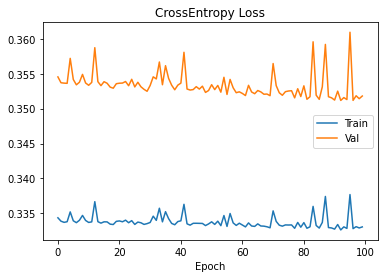

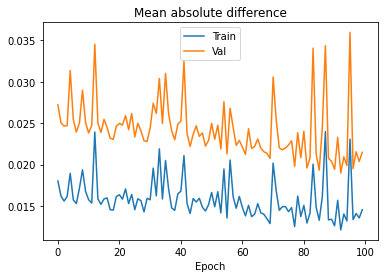

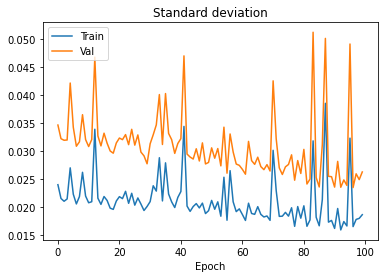

In [ ]:
%%time
optimizer = optim.RMSprop(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

### Modèle 3

In [ ]:
n_layers = 10
n_hidden = 800

model = MLP(input_size, n_layers, n_hidden)
summary(model, (input_size,25,),dtypes=(torch.double,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [25, 800]                 --
|    └─Linear: 2-1                       [25, 800]                 20,800
|    └─SELU: 2-2                         [25, 800]                 --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-3                   [25, 800]                 --
|    |    └─Linear: 3-1                  [25, 400]                 320,400
|    |    └─BatchNorm1d: 3-2             [25, 400]                 800
|    |    └─SELU: 3-3                    [25, 400]                 --
|    |    └─Linear: 3-4                  [25, 800]                 320,800
|    |    └─BatchNorm1d: 3-5             [25, 800]                 1,600
|    |    └─SELU: 3-6                    [25, 800]                 --
|    └─Sequential: 2-4                   [25, 800]                 --
|    |    └─Linear: 3-7                  [25, 400]                 

Epoch 10
Train loss: 0.337 	Val loss: 0.362
Train difference: 2.30e-02 	Val difference: 3.75e-02
Train standard deviation: 3.38e-02 	Val standard deviation: 5.50e-02

Epoch 20
Train loss: 0.336 	Val loss: 0.359
Train difference: 2.14e-02 	Val difference: 3.39e-02
Train standard deviation: 2.95e-02 	Val standard deviation: 4.66e-02

Epoch 30
Train loss: 0.334 	Val loss: 0.355
Train difference: 1.77e-02 	Val difference: 2.73e-02
Train standard deviation: 2.41e-02 	Val standard deviation: 3.69e-02

Epoch 40
Train loss: 0.334 	Val loss: 0.353
Train difference: 1.60e-02 	Val difference: 2.45e-02
Train standard deviation: 2.09e-02 	Val standard deviation: 3.08e-02

Epoch 50
Train loss: 0.333 	Val loss: 0.352
Train difference: 1.49e-02 	Val difference: 2.15e-02
Train standard deviation: 1.83e-02 	Val standard deviation: 2.59e-02

Epoch 60
Train loss: 0.333 	Val loss: 0.352
Train difference: 1.44e-02 	Val difference: 2.02e-02
Train standard deviation: 1.60e-02 	Val standard deviation: 2.25e-02

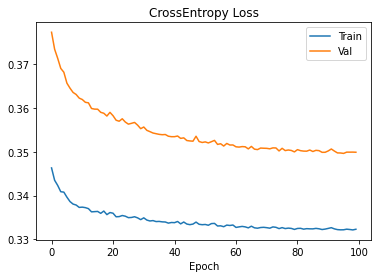

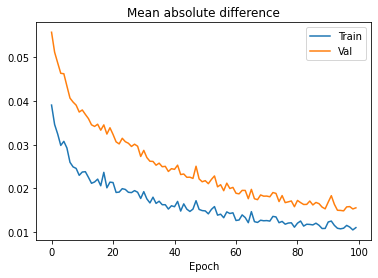

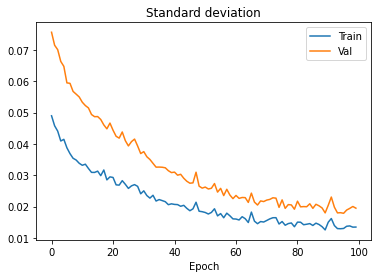

In [ ]:
%%time
optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

### Modèle 4

Epoch 10
Train loss: 0.335 	Val loss: 0.355
Train difference: 2.26e-02 	Val difference: 2.98e-02
Train standard deviation: 2.55e-02 	Val standard deviation: 3.42e-02

Epoch 20
Train loss: 0.333 	Val loss: 0.350
Train difference: 1.27e-02 	Val difference: 1.76e-02
Train standard deviation: 1.56e-02 	Val standard deviation: 2.17e-02

Epoch 30
Train loss: 0.333 	Val loss: 0.351
Train difference: 1.40e-02 	Val difference: 1.98e-02
Train standard deviation: 1.72e-02 	Val standard deviation: 2.44e-02

Epoch 40
Train loss: 0.333 	Val loss: 0.350
Train difference: 1.23e-02 	Val difference: 1.69e-02
Train standard deviation: 1.47e-02 	Val standard deviation: 2.06e-02

Epoch 50
Train loss: 0.333 	Val loss: 0.350
Train difference: 1.48e-02 	Val difference: 1.82e-02
Train standard deviation: 1.60e-02 	Val standard deviation: 2.04e-02

Epoch 60
Train loss: 0.332 	Val loss: 0.350
Train difference: 1.19e-02 	Val difference: 1.64e-02
Train standard deviation: 1.40e-02 	Val standard deviation: 1.97e-02

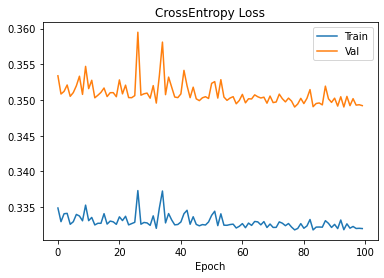

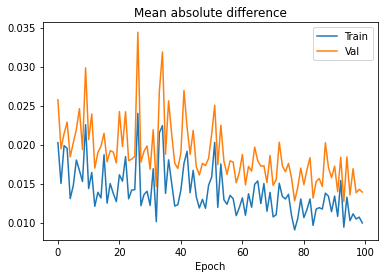

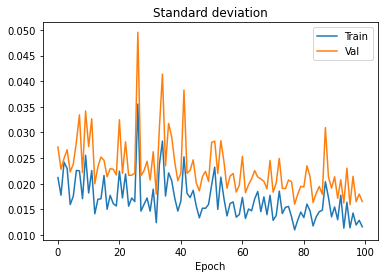

In [ ]:
%%time
optimizer = optim.RMSprop(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

### Modèle 5

Epoch 10
Train loss: 0.333 	Val loss: 0.351
Train difference: 1.55e-02 	Val difference: 1.95e-02
Train standard deviation: 1.83e-02 	Val standard deviation: 2.33e-02

Epoch 20
Train loss: 0.333 	Val loss: 0.352
Train difference: 1.49e-02 	Val difference: 2.09e-02
Train standard deviation: 1.74e-02 	Val standard deviation: 2.58e-02

Epoch 30
Train loss: 0.336 	Val loss: 0.354
Train difference: 2.43e-02 	Val difference: 2.87e-02
Train standard deviation: 2.70e-02 	Val standard deviation: 3.20e-02

Epoch 40
Train loss: 0.335 	Val loss: 0.356
Train difference: 1.71e-02 	Val difference: 2.56e-02
Train standard deviation: 3.03e-02 	Val standard deviation: 4.37e-02

Epoch 50
Train loss: 0.332 	Val loss: 0.350
Train difference: 1.23e-02 	Val difference: 1.71e-02
Train standard deviation: 1.53e-02 	Val standard deviation: 2.24e-02

Epoch 60
Train loss: 0.332 	Val loss: 0.350
Train difference: 1.28e-02 	Val difference: 1.69e-02
Train standard deviation: 1.42e-02 	Val standard deviation: 1.92e-02

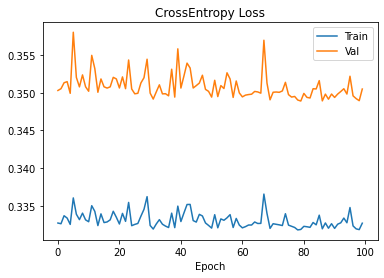

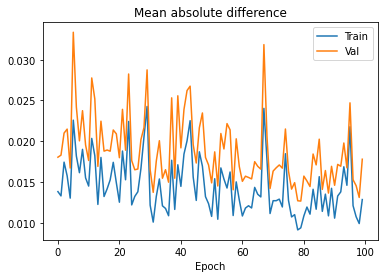

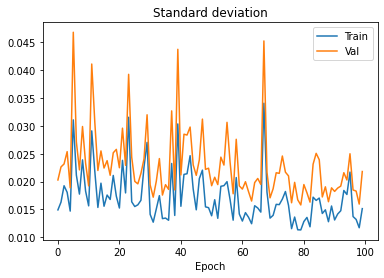

In [ ]:
%%time
optimizer = optim.RMSprop(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

### Modèle 6

In [ ]:
n_layers = 5
n_hidden = 800

model = MLP(input_size, n_layers, n_hidden)
summary(model, (input_size,25,),dtypes=(torch.double,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [25, 800]                 --
|    └─Linear: 2-1                       [25, 800]                 20,800
|    └─SELU: 2-2                         [25, 800]                 --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-3                   [25, 800]                 --
|    |    └─Linear: 3-1                  [25, 400]                 320,400
|    |    └─BatchNorm1d: 3-2             [25, 400]                 800
|    |    └─SELU: 3-3                    [25, 400]                 --
|    |    └─Linear: 3-4                  [25, 800]                 320,800
|    |    └─BatchNorm1d: 3-5             [25, 800]                 1,600
|    |    └─SELU: 3-6                    [25, 800]                 --
|    └─Sequential: 2-4                   [25, 800]                 --
|    |    └─Linear: 3-7                  [25, 400]                 

Epoch 10
Train loss: 0.338 	Val loss: 0.365
Train difference: 2.52e-02 	Val difference: 4.10e-02
Train standard deviation: 3.66e-02 	Val standard deviation: 5.91e-02

Epoch 20
Train loss: 0.336 	Val loss: 0.361
Train difference: 2.06e-02 	Val difference: 3.52e-02
Train standard deviation: 3.22e-02 	Val standard deviation: 5.24e-02

Epoch 30
Train loss: 0.336 	Val loss: 0.359
Train difference: 1.91e-02 	Val difference: 3.25e-02
Train standard deviation: 3.00e-02 	Val standard deviation: 4.88e-02

Epoch 40
Train loss: 0.335 	Val loss: 0.357
Train difference: 1.82e-02 	Val difference: 3.01e-02
Train standard deviation: 2.67e-02 	Val standard deviation: 4.16e-02

Epoch 50
Train loss: 0.335 	Val loss: 0.355
Train difference: 1.80e-02 	Val difference: 2.78e-02
Train standard deviation: 2.41e-02 	Val standard deviation: 3.68e-02

Epoch 60
Train loss: 0.334 	Val loss: 0.354
Train difference: 1.64e-02 	Val difference: 2.60e-02
Train standard deviation: 2.25e-02 	Val standard deviation: 3.40e-02

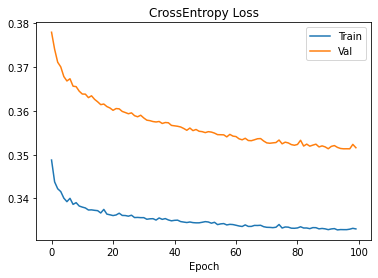

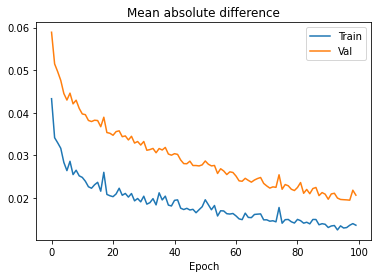

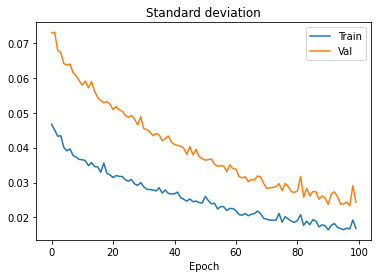

In [ ]:
%%time
optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

### Modèle 7

In [ ]:
n_layers = 10
n_hidden = 1200

model = MLP(input_size, n_layers, n_hidden)
summary(model, (input_size,25,),dtypes=(torch.double,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [25, 1200]                --
|    └─Linear: 2-1                       [25, 1200]                31,200
|    └─SELU: 2-2                         [25, 1200]                --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-3                   [25, 1200]                --
|    |    └─Linear: 3-1                  [25, 600]                 720,600
|    |    └─BatchNorm1d: 3-2             [25, 600]                 1,200
|    |    └─SELU: 3-3                    [25, 600]                 --
|    |    └─Linear: 3-4                  [25, 1200]                721,200
|    |    └─BatchNorm1d: 3-5             [25, 1200]                2,400
|    |    └─SELU: 3-6                    [25, 1200]                --
|    └─Sequential: 2-4                   [25, 1200]                --
|    |    └─Linear: 3-7                  [25, 600]               

Epoch 10
Train loss: 0.337 	Val loss: 0.361
Train difference: 2.44e-02 	Val difference: 3.69e-02
Train standard deviation: 3.28e-02 	Val standard deviation: 5.08e-02

Epoch 20
Train loss: 0.337 	Val loss: 0.358
Train difference: 2.52e-02 	Val difference: 3.59e-02
Train standard deviation: 2.98e-02 	Val standard deviation: 4.19e-02

Epoch 30
Train loss: 0.334 	Val loss: 0.354
Train difference: 1.71e-02 	Val difference: 2.60e-02
Train standard deviation: 2.31e-02 	Val standard deviation: 3.44e-02

Epoch 40
Train loss: 0.333 	Val loss: 0.353
Train difference: 1.52e-02 	Val difference: 2.30e-02
Train standard deviation: 2.02e-02 	Val standard deviation: 3.00e-02

Epoch 50
Train loss: 0.333 	Val loss: 0.352
Train difference: 1.52e-02 	Val difference: 2.19e-02
Train standard deviation: 1.90e-02 	Val standard deviation: 2.65e-02

Epoch 60
Train loss: 0.333 	Val loss: 0.351
Train difference: 1.33e-02 	Val difference: 1.91e-02
Train standard deviation: 1.62e-02 	Val standard deviation: 2.29e-02

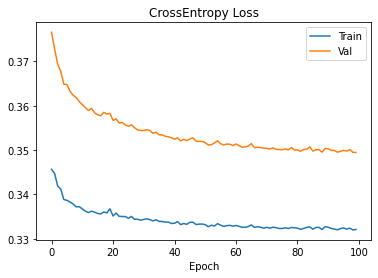

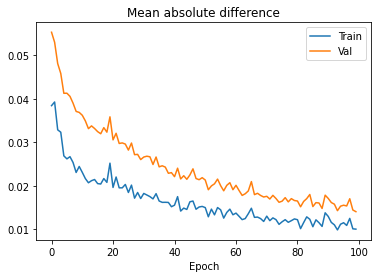

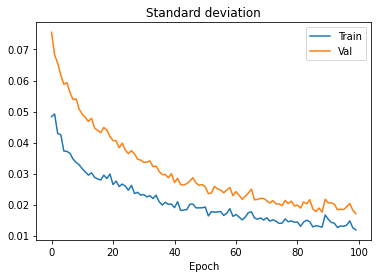

In [ ]:
%%time
optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

### Modèle 8

In [ ]:
n_layers = 15
n_hidden = 800

model = MLP(input_size, n_layers, n_hidden)
summary(model, (input_size,25,),dtypes=(torch.double,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [25, 800]                 --
|    └─Linear: 2-1                       [25, 800]                 20,800
|    └─SELU: 2-2                         [25, 800]                 --
├─ModuleList: 1                          []                        --
|    └─Sequential: 2-3                   [25, 800]                 --
|    |    └─Linear: 3-1                  [25, 400]                 320,400
|    |    └─BatchNorm1d: 3-2             [25, 400]                 800
|    |    └─SELU: 3-3                    [25, 400]                 --
|    |    └─Linear: 3-4                  [25, 800]                 320,800
|    |    └─BatchNorm1d: 3-5             [25, 800]                 1,600
|    |    └─SELU: 3-6                    [25, 800]                 --
|    └─Sequential: 2-4                   [25, 800]                 --
|    |    └─Linear: 3-7                  [25, 400]                 

Epoch 10
Train loss: 0.337 	Val loss: 0.361
Train difference: 2.23e-02 	Val difference: 3.60e-02
Train standard deviation: 3.22e-02 	Val standard deviation: 5.19e-02

Epoch 20
Train loss: 0.335 	Val loss: 0.356
Train difference: 1.93e-02 	Val difference: 2.96e-02
Train standard deviation: 2.65e-02 	Val standard deviation: 4.05e-02

Epoch 30
Train loss: 0.334 	Val loss: 0.354
Train difference: 1.77e-02 	Val difference: 2.54e-02
Train standard deviation: 2.25e-02 	Val standard deviation: 3.21e-02

Epoch 40
Train loss: 0.334 	Val loss: 0.353
Train difference: 1.66e-02 	Val difference: 2.30e-02
Train standard deviation: 2.03e-02 	Val standard deviation: 2.79e-02

Epoch 50
Train loss: 0.333 	Val loss: 0.351
Train difference: 1.36e-02 	Val difference: 1.89e-02
Train standard deviation: 1.61e-02 	Val standard deviation: 2.19e-02

Epoch 60
Train loss: 0.333 	Val loss: 0.351
Train difference: 1.32e-02 	Val difference: 1.88e-02
Train standard deviation: 1.55e-02 	Val standard deviation: 2.17e-02

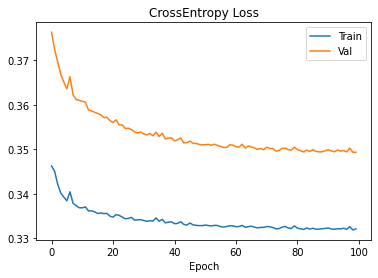

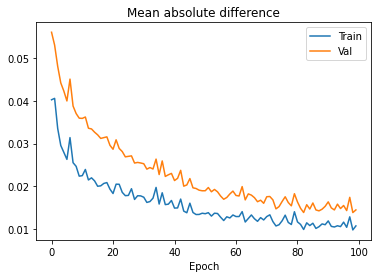

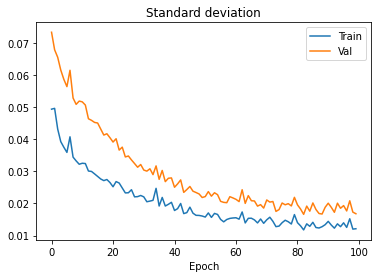

In [ ]:
%%time
optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

## Changement du lr avec BCE

### Changement lr

In [ ]:
batch_size = 200
input_size = X_train.shape[1]
lr = 1e-3
epochs = 100
criterion = nn.BCELoss()
print_each = 10
n_layers = 5
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

Epoch 10
Train loss: 0.338 	Val loss: 0.367
Train difference: 2.49e-02 	Val difference: 4.39e-02
Train standard deviation: 4.13e-02 	Val standard deviation: 6.64e-02

Epoch 20
Train loss: 0.338 	Val loss: 0.366
Train difference: 2.22e-02 	Val difference: 4.11e-02
Train standard deviation: 3.95e-02 	Val standard deviation: 6.54e-02

Epoch 30
Train loss: 0.337 	Val loss: 0.364
Train difference: 1.81e-02 	Val difference: 3.73e-02
Train standard deviation: 3.77e-02 	Val standard deviation: 6.43e-02

Epoch 40
Train loss: 0.336 	Val loss: 0.363
Train difference: 1.84e-02 	Val difference: 3.65e-02
Train standard deviation: 3.61e-02 	Val standard deviation: 6.03e-02

Epoch 50
Train loss: 0.336 	Val loss: 0.362
Train difference: 2.00e-02 	Val difference: 3.70e-02
Train standard deviation: 3.45e-02 	Val standard deviation: 5.63e-02

Epoch 60
Train loss: 0.336 	Val loss: 0.361
Train difference: 1.66e-02 	Val difference: 3.41e-02
Train standard deviation: 3.39e-02 	Val standard deviation: 5.65e-02

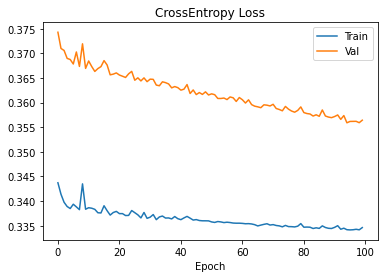

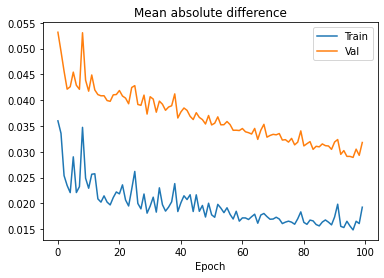

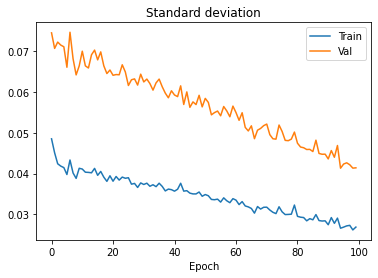

In [ ]:
%%time
optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 0.337 	Val loss: 0.364
Train difference: 2.14e-02 	Val difference: 3.86e-02
Train standard deviation: 3.71e-02 	Val standard deviation: 6.20e-02

Epoch 20
Train loss: 0.337 	Val loss: 0.363
Train difference: 2.22e-02 	Val difference: 3.85e-02
Train standard deviation: 3.66e-02 	Val standard deviation: 5.92e-02

Epoch 30
Train loss: 0.336 	Val loss: 0.361
Train difference: 1.90e-02 	Val difference: 3.54e-02
Train standard deviation: 3.21e-02 	Val standard deviation: 5.30e-02

Epoch 40
Train loss: 0.336 	Val loss: 0.359
Train difference: 1.92e-02 	Val difference: 3.40e-02
Train standard deviation: 3.10e-02 	Val standard deviation: 4.98e-02

Epoch 50
Train loss: 0.335 	Val loss: 0.357
Train difference: 1.70e-02 	Val difference: 3.05e-02
Train standard deviation: 2.73e-02 	Val standard deviation: 4.33e-02

Epoch 60
Train loss: 0.335 	Val loss: 0.357
Train difference: 1.62e-02 	Val difference: 2.98e-02
Train standard deviation: 2.79e-02 	Val standard deviation: 4.41e-02

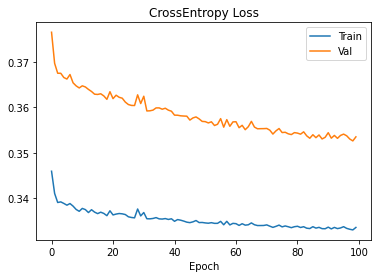

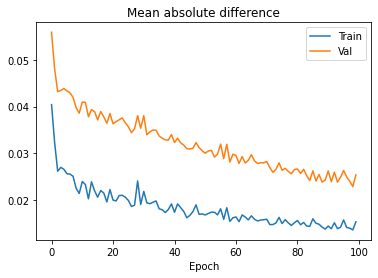

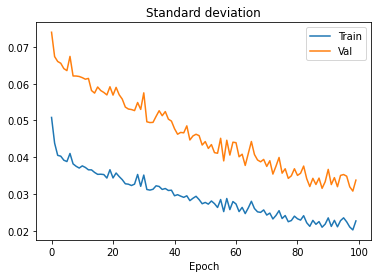

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 100
criterion = nn.BCELoss()
print_each = 10
n_layers = 5
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 0.340 	Val loss: 0.369
Train difference: 2.76e-02 	Val difference: 4.49e-02
Train standard deviation: 4.07e-02 	Val standard deviation: 6.71e-02

Epoch 20
Train loss: 0.338 	Val loss: 0.365
Train difference: 2.39e-02 	Val difference: 4.05e-02
Train standard deviation: 3.71e-02 	Val standard deviation: 6.09e-02

Epoch 30
Train loss: 0.337 	Val loss: 0.363
Train difference: 2.21e-02 	Val difference: 3.79e-02
Train standard deviation: 3.48e-02 	Val standard deviation: 5.75e-02

Epoch 40
Train loss: 0.336 	Val loss: 0.361
Train difference: 2.09e-02 	Val difference: 3.59e-02
Train standard deviation: 3.24e-02 	Val standard deviation: 5.26e-02

Epoch 50
Train loss: 0.336 	Val loss: 0.360
Train difference: 2.02e-02 	Val difference: 3.46e-02
Train standard deviation: 3.15e-02 	Val standard deviation: 5.13e-02

Epoch 60
Train loss: 0.336 	Val loss: 0.359
Train difference: 1.96e-02 	Val difference: 3.28e-02
Train standard deviation: 2.96e-02 	Val standard deviation: 4.72e-02

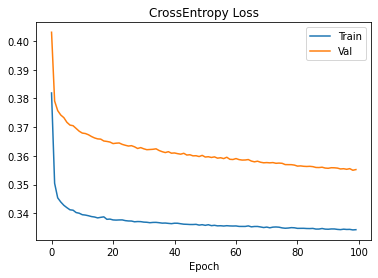

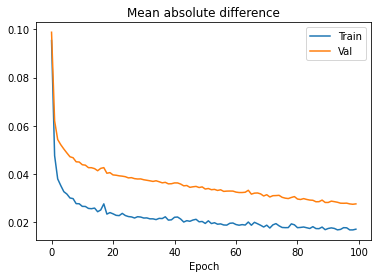

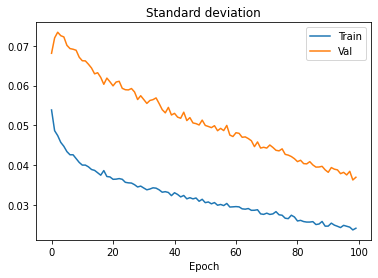

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-5
epochs = 100
criterion = nn.BCELoss()
print_each = 10
n_layers = 5
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

### Si on utilise un scheduler et un LR = 1e-2

In [ ]:
def train(model, data_train, data_val,
          criterion, optimizer, epochs,
          print_each=1):
  
    train_loss, train_diff, train_std = [], [], []
    val_loss, val_diff, val_std = [], [], []
    best_diff = 100
    best_std = 100
    best_model = None
    logger = Logger()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    cuda = torch.cuda.is_available()
    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    
    for e in range(1, epochs+1):
        model.train()
        for rows, values in data_train:
            if cuda:
                rows = rows.cuda()
                values = values.cuda()

            pred = model(rows).squeeze()
            loss = criterion(pred, values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train, diff_train, std_train = eval_dataset(model, criterion, data_train)
        train_loss.append(loss_train)
        train_diff.append(diff_train)
        train_std.append(std_train)
        
        loss_val, diff_val, std_val = eval_dataset(model, criterion, data_val)
        val_loss.append(loss_val)
        val_diff.append(diff_val)
        val_std.append(std_val)

        if diff_val < best_diff: # On garde le meilleur modèle obtenu jusqu'à maintenant 
            best_diff = diff_val
            best_std = std_val
            best_model = model

        logger.log(loss_train, diff_train, std_train, loss_val, diff_val, std_val)
        scheduler.step(loss_val)
        
        if e % print_each == 0:
            print(f'Epoch {e}')
            print(f'Train loss: {train_loss[-1]:.3f} \tVal loss: {val_loss[-1]:.3f}')
            print(f'Train difference: {train_diff[-1]:.2e} \tVal difference: {val_diff[-1]:.2e}')
            print(f'Train standard deviation: {train_std[-1]:.2e} \tVal standard deviation: {val_std[-1]:.2e}\n')
    
    return best_model, logger, best_diff, best_std

Epoch 10
Train loss: 0.339 	Val loss: 0.369
Train difference: 2.39e-02 	Val difference: 4.31e-02
Train standard deviation: 4.25e-02 	Val standard deviation: 7.19e-02

Epoch 20
Train loss: 0.337 	Val loss: 0.366
Train difference: 1.96e-02 	Val difference: 3.96e-02
Train standard deviation: 3.87e-02 	Val standard deviation: 6.50e-02

Epoch 30
Train loss: 0.337 	Val loss: 0.364
Train difference: 2.31e-02 	Val difference: 4.11e-02
Train standard deviation: 3.72e-02 	Val standard deviation: 6.15e-02

Epoch 40
Train loss: 0.336 	Val loss: 0.362
Train difference: 1.94e-02 	Val difference: 3.75e-02
Train standard deviation: 3.50e-02 	Val standard deviation: 5.82e-02

Epoch 50
Train loss: 0.336 	Val loss: 0.362
Train difference: 1.86e-02 	Val difference: 3.61e-02
Train standard deviation: 3.44e-02 	Val standard deviation: 5.70e-02

Epoch 60
Train loss: 0.336 	Val loss: 0.361
Train difference: 1.72e-02 	Val difference: 3.56e-02
Train standard deviation: 3.37e-02 	Val standard deviation: 5.54e-02

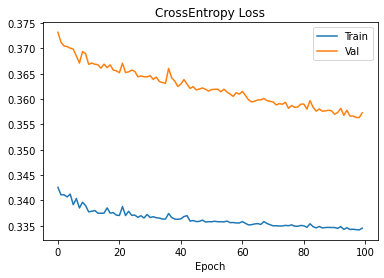

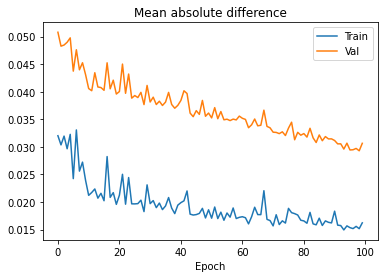

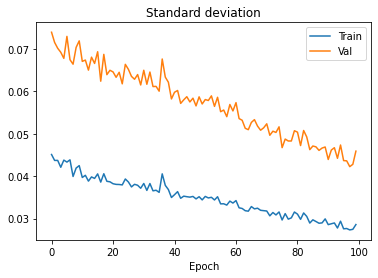

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-3
epochs = 100
criterion = nn.BCELoss()
print_each = 10
n_layers = 5
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

## Changement de loss : MSE

In [ ]:
def train(model, data_train, data_val,
          criterion, optimizer, epochs,
          print_each=1):
  
    train_loss, train_diff, train_std = [], [], []
    val_loss, val_diff, val_std = [], [], []
    best_diff = 100
    best_std = 100
    best_model = None
    logger = Logger()
    
    cuda = torch.cuda.is_available()
    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    
    for e in range(1, epochs+1):
        model.train()
        for rows, values in data_train:
            if cuda:
                rows = rows.cuda()
                values = values.cuda()

            pred = model(rows).squeeze()
            loss = criterion(pred, values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train, diff_train, std_train = eval_dataset(model, criterion, data_train)
        train_loss.append(loss_train)
        train_diff.append(diff_train)
        train_std.append(std_train)
        
        loss_val, diff_val, std_val = eval_dataset(model, criterion, data_val)
        val_loss.append(loss_val)
        val_diff.append(diff_val)
        val_std.append(std_val)

        if diff_val < best_diff: # On garde le meilleur modèle obtenu jusqu'à maintenant 
            best_diff = diff_val
            best_std = std_val
            best_model = model

        logger.log(loss_train, diff_train, std_train, loss_val, diff_val, std_val)
        
        if e % print_each == 0:
            print(f'Epoch {e}')
            print(f'Train loss: {train_loss[-1]:.2e} \tVal loss: {val_loss[-1]:.2e}')
            print(f'Train difference: {train_diff[-1]:.2e} \tVal difference: {val_diff[-1]:.2e}')
            print(f'Train standard deviation: {train_std[-1]:.2e} \tVal standard deviation: {val_std[-1]:.2e}\n')
    
    return best_model, logger, best_diff, best_std

Epoch 10
Train loss: 2.49e-03 	Val loss: 7.08e-03
Train difference: 2.59e-02 	Val difference: 4.40e-02
Train standard deviation: 4.27e-02 	Val standard deviation: 7.18e-02

Epoch 20
Train loss: 1.98e-03 	Val loss: 5.92e-03
Train difference: 2.24e-02 	Val difference: 4.15e-02
Train standard deviation: 3.85e-02 	Val standard deviation: 6.48e-02

Epoch 30
Train loss: 2.10e-03 	Val loss: 5.93e-03
Train difference: 2.56e-02 	Val difference: 4.57e-02
Train standard deviation: 3.80e-02 	Val standard deviation: 6.20e-02

Epoch 40
Train loss: 1.79e-03 	Val loss: 5.37e-03
Train difference: 2.00e-02 	Val difference: 3.84e-02
Train standard deviation: 3.73e-02 	Val standard deviation: 6.24e-02

Epoch 50
Train loss: 1.66e-03 	Val loss: 5.15e-03
Train difference: 1.82e-02 	Val difference: 3.63e-02
Train standard deviation: 3.65e-02 	Val standard deviation: 6.19e-02

Epoch 60
Train loss: 1.53e-03 	Val loss: 4.62e-03
Train difference: 1.82e-02 	Val difference: 3.67e-02
Train standard deviation: 3.47e-

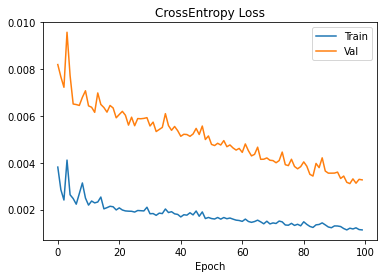

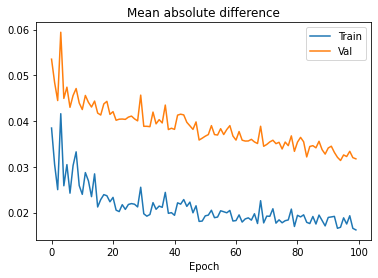

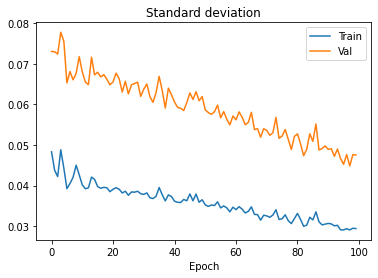

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-3
epochs = 100
criterion = nn.MSELoss()
print_each = 10
n_layers = 5
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 1.95e-03 	Val loss: 5.33e-03
Train difference: 2.55e-02 	Val difference: 4.26e-02
Train standard deviation: 3.60e-02 	Val standard deviation: 5.93e-02

Epoch 20
Train loss: 1.88e-03 	Val loss: 4.87e-03
Train difference: 2.54e-02 	Val difference: 4.06e-02
Train standard deviation: 3.52e-02 	Val standard deviation: 5.67e-02

Epoch 30
Train loss: 1.48e-03 	Val loss: 4.13e-03
Train difference: 2.06e-02 	Val difference: 3.61e-02
Train standard deviation: 3.25e-02 	Val standard deviation: 5.32e-02

Epoch 40
Train loss: 1.29e-03 	Val loss: 3.48e-03
Train difference: 2.00e-02 	Val difference: 3.49e-02
Train standard deviation: 2.98e-02 	Val standard deviation: 4.76e-02

Epoch 50
Train loss: 1.44e-03 	Val loss: 3.53e-03
Train difference: 2.24e-02 	Val difference: 3.54e-02
Train standard deviation: 3.07e-02 	Val standard deviation: 4.77e-02

Epoch 60
Train loss: 1.03e-03 	Val loss: 2.68e-03
Train difference: 1.83e-02 	Val difference: 3.11e-02
Train standard deviation: 2.64e-

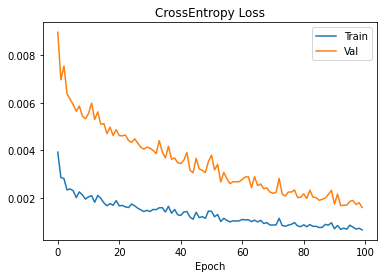

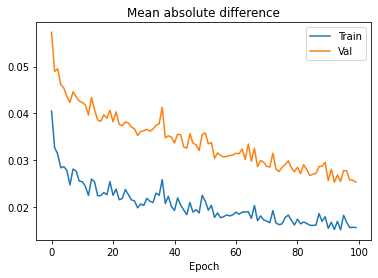

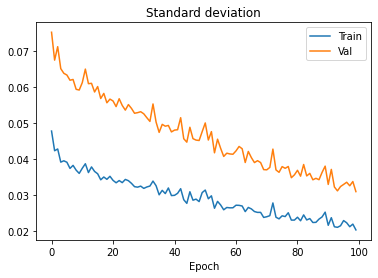

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 100
criterion = nn.MSELoss()
print_each = 10
n_layers = 5
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 2.57e-03 	Val loss: 6.70e-03
Train difference: 3.08e-02 	Val difference: 4.78e-02
Train standard deviation: 4.02e-02 	Val standard deviation: 6.64e-02

Epoch 20
Train loss: 2.10e-03 	Val loss: 5.34e-03
Train difference: 2.75e-02 	Val difference: 4.30e-02
Train standard deviation: 3.67e-02 	Val standard deviation: 5.91e-02

Epoch 30
Train loss: 1.72e-03 	Val loss: 4.65e-03
Train difference: 2.43e-02 	Val difference: 4.00e-02
Train standard deviation: 3.36e-02 	Val standard deviation: 5.52e-02

Epoch 40
Train loss: 1.55e-03 	Val loss: 4.14e-03
Train difference: 2.28e-02 	Val difference: 3.74e-02
Train standard deviation: 3.20e-02 	Val standard deviation: 5.23e-02

Epoch 50
Train loss: 1.37e-03 	Val loss: 3.63e-03
Train difference: 2.18e-02 	Val difference: 3.57e-02
Train standard deviation: 2.99e-02 	Val standard deviation: 4.85e-02

Epoch 60
Train loss: 1.26e-03 	Val loss: 3.23e-03
Train difference: 2.12e-02 	Val difference: 3.42e-02
Train standard deviation: 2.85e-

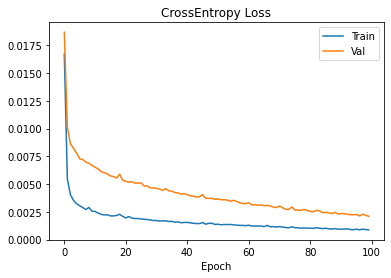

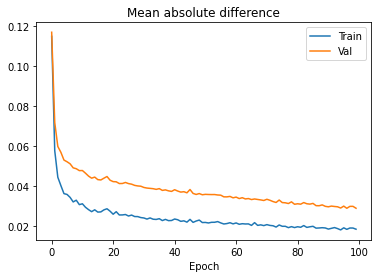

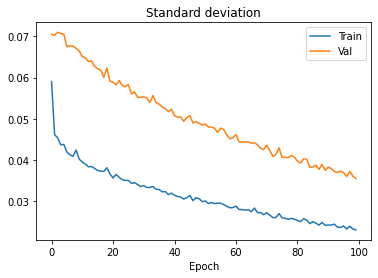

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-5
epochs = 100
criterion = nn.MSELoss()
print_each = 10
n_layers = 5
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test,
              criterion, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

## Changement de loss : RNN_criterion

### Changement de learning rate

In [ ]:
def RNN_criterion(pred, values):
    """
    Retourne la moyenne de l'écart des logs des prédictions.
    Inverse chaque prédiction dont la valeur est inferieure à 0.5 par 1 - valeur (stabilité du log).
    """
    ones = torch.ones(values.shape).to(values.device)
    loss = torch.log(ones - torch.abs(pred - values)).view(-1)
    return -torch.mean(loss)

In [ ]:
torch.set_default_dtype(torch.double)

def eval_dataset(model, dataloader):
    model.eval()
    losses = []
    diff = []
    
    cuda = torch.cuda.is_available()
    if cuda:
        model = model.cuda()
    
    for rows, values in dataloader:
        if cuda:
            rows = rows.cuda()
            values = values.cuda()

        output = model(rows).squeeze()

        loss = RNN_criterion(output, values).item()
        diff.extend(abs(output-values).tolist())
        losses.append(loss)
    return np.mean(losses), np.mean(diff), np.std(diff)

def train(model, data_train, data_val,
          optimizer, epochs,
          print_each=1):
  
    train_loss, train_diff, train_std = [], [], []
    val_loss, val_diff, val_std = [], [], []
    best_diff = 100
    best_std = 100
    best_model = None
    logger = Logger()
    
    cuda = torch.cuda.is_available()
    if cuda:
        model = model.cuda()
    
    for e in range(1, epochs+1):
        model.train()
        for rows, values in data_train:
            if cuda:
                rows = rows.cuda()
                values = values.cuda()

            pred = model(rows).squeeze()
            loss = RNN_criterion(pred, values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train, diff_train, std_train = eval_dataset(model, data_train)
        train_loss.append(loss_train)
        train_diff.append(diff_train)
        train_std.append(std_train)
        
        loss_val, diff_val, std_val = eval_dataset(model, data_val)
        val_loss.append(loss_val)
        val_diff.append(diff_val)
        val_std.append(std_val)

        if diff_val < best_diff: # On garde le meilleur modèle obtenu jusqu'à maintenant 
            best_diff = diff_val
            best_std = std_val
            best_model = model

        logger.log(loss_train, diff_train, std_train, loss_val, diff_val, std_val)
        
        if e % print_each == 0:
            print(f'Epoch {e}')
            print(f'Train loss: {train_loss[-1]:.2e} \tVal loss: {val_loss[-1]:.2e}')
            print(f'Train difference: {train_diff[-1]:.2e} \tVal difference: {val_diff[-1]:.2e}')
            print(f'Train standard deviation: {train_std[-1]:.2e} \tVal standard deviation: {val_std[-1]:.2e}\n')
    
    return best_model, logger, best_diff, best_std

Epoch 10
Train loss: 2.54e-02 	Val loss: 5.02e-02
Train difference: 2.37e-02 	Val difference: 4.46e-02
Train standard deviation: 4.39e-02 	Val standard deviation: 7.61e-02

Epoch 20
Train loss: 1.96e-02 	Val loss: 4.40e-02
Train difference: 1.82e-02 	Val difference: 3.92e-02
Train standard deviation: 4.15e-02 	Val standard deviation: 7.26e-02

Epoch 30
Train loss: 1.87e-02 	Val loss: 4.31e-02
Train difference: 1.74e-02 	Val difference: 3.85e-02
Train standard deviation: 4.13e-02 	Val standard deviation: 7.16e-02

Epoch 40
Train loss: 2.08e-02 	Val loss: 4.53e-02
Train difference: 1.94e-02 	Val difference: 4.05e-02
Train standard deviation: 4.22e-02 	Val standard deviation: 7.25e-02

Epoch 50
Train loss: 1.92e-02 	Val loss: 4.13e-02
Train difference: 1.80e-02 	Val difference: 3.71e-02
Train standard deviation: 3.91e-02 	Val standard deviation: 6.83e-02

Epoch 60
Train loss: 1.73e-02 	Val loss: 3.97e-02
Train difference: 1.62e-02 	Val difference: 3.60e-02
Train standard deviation: 3.81e-

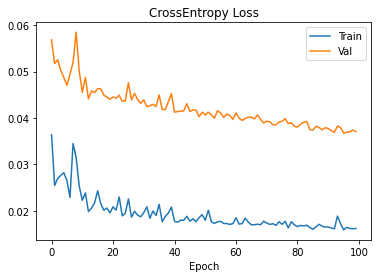

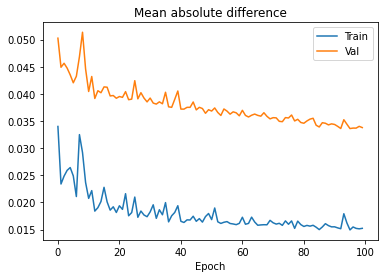

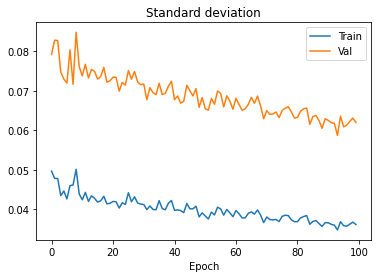

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-3
epochs = 100
print_each = 10
n_layers = 5
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 2.23e-02 	Val loss: 4.61e-02
Train difference: 2.07e-02 	Val difference: 4.10e-02
Train standard deviation: 4.24e-02 	Val standard deviation: 7.38e-02

Epoch 20
Train loss: 2.38e-02 	Val loss: 4.36e-02
Train difference: 2.24e-02 	Val difference: 3.93e-02
Train standard deviation: 3.98e-02 	Val standard deviation: 6.79e-02

Epoch 30
Train loss: 1.95e-02 	Val loss: 4.26e-02
Train difference: 1.82e-02 	Val difference: 3.83e-02
Train standard deviation: 4.00e-02 	Val standard deviation: 6.93e-02

Epoch 40
Train loss: 1.86e-02 	Val loss: 3.86e-02
Train difference: 1.75e-02 	Val difference: 3.50e-02
Train standard deviation: 3.70e-02 	Val standard deviation: 6.40e-02

Epoch 50
Train loss: 1.73e-02 	Val loss: 3.75e-02
Train difference: 1.63e-02 	Val difference: 3.42e-02
Train standard deviation: 3.59e-02 	Val standard deviation: 6.19e-02

Epoch 60
Train loss: 1.75e-02 	Val loss: 3.72e-02
Train difference: 1.65e-02 	Val difference: 3.40e-02
Train standard deviation: 3.59e-

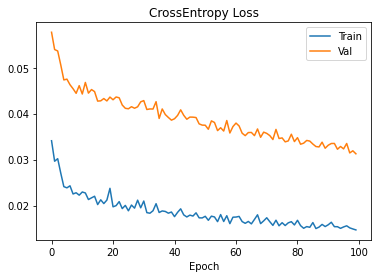

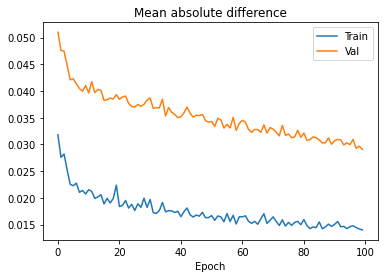

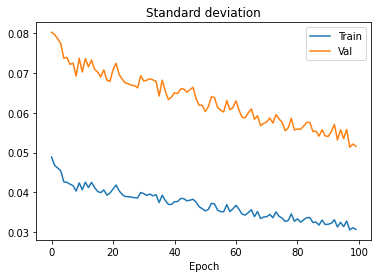

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 100
print_each = 10
n_layers = 5
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 2.80e-02 	Val loss: 5.11e-02
Train difference: 2.61e-02 	Val difference: 4.52e-02
Train standard deviation: 4.49e-02 	Val standard deviation: 7.66e-02

Epoch 20
Train loss: 2.38e-02 	Val loss: 4.64e-02
Train difference: 2.22e-02 	Val difference: 4.12e-02
Train standard deviation: 4.23e-02 	Val standard deviation: 7.35e-02

Epoch 30
Train loss: 2.19e-02 	Val loss: 4.39e-02
Train difference: 2.05e-02 	Val difference: 3.92e-02
Train standard deviation: 4.07e-02 	Val standard deviation: 7.11e-02

Epoch 40
Train loss: 2.13e-02 	Val loss: 4.21e-02
Train difference: 2.00e-02 	Val difference: 3.78e-02
Train standard deviation: 3.92e-02 	Val standard deviation: 6.84e-02

Epoch 50
Train loss: 1.98e-02 	Val loss: 4.12e-02
Train difference: 1.85e-02 	Val difference: 3.69e-02
Train standard deviation: 3.92e-02 	Val standard deviation: 6.87e-02

Epoch 60
Train loss: 2.05e-02 	Val loss: 4.03e-02
Train difference: 1.93e-02 	Val difference: 3.63e-02
Train standard deviation: 3.81e-

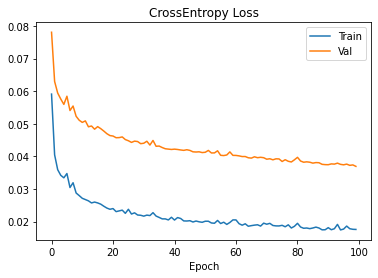

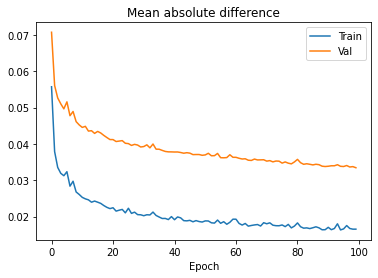

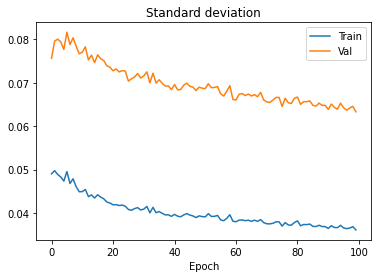

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-5
epochs = 100
print_each = 10
n_layers = 5
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

### Changement des autres hyperparamètres à lr fixé

Epoch 10
Train loss: 2.42e-02 	Val loss: 4.45e-02
Train difference: 2.28e-02 	Val difference: 4.01e-02
Train standard deviation: 4.02e-02 	Val standard deviation: 6.81e-02

Epoch 20
Train loss: 2.12e-02 	Val loss: 4.71e-02
Train difference: 1.96e-02 	Val difference: 4.17e-02
Train standard deviation: 4.46e-02 	Val standard deviation: 7.73e-02

Epoch 30
Train loss: 1.90e-02 	Val loss: 4.17e-02
Train difference: 1.78e-02 	Val difference: 3.75e-02
Train standard deviation: 3.98e-02 	Val standard deviation: 6.92e-02

Epoch 40
Train loss: 1.91e-02 	Val loss: 4.07e-02
Train difference: 1.79e-02 	Val difference: 3.68e-02
Train standard deviation: 3.84e-02 	Val standard deviation: 6.60e-02

Epoch 50
Train loss: 1.76e-02 	Val loss: 3.99e-02
Train difference: 1.65e-02 	Val difference: 3.59e-02
Train standard deviation: 3.91e-02 	Val standard deviation: 6.73e-02

Epoch 60
Train loss: 1.74e-02 	Val loss: 3.79e-02
Train difference: 1.64e-02 	Val difference: 3.46e-02
Train standard deviation: 3.59e-

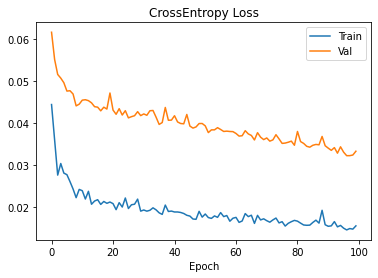

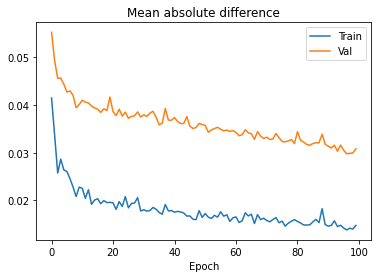

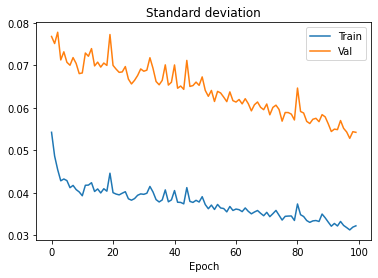

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 100
print_each = 10
n_layers = 5
n_hidden = 800

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 2.53e-02 	Val loss: 4.79e-02
Train difference: 2.37e-02 	Val difference: 4.29e-02
Train standard deviation: 4.23e-02 	Val standard deviation: 7.27e-02

Epoch 20
Train loss: 2.07e-02 	Val loss: 4.49e-02
Train difference: 1.93e-02 	Val difference: 4.00e-02
Train standard deviation: 4.18e-02 	Val standard deviation: 7.28e-02

Epoch 30
Train loss: 1.98e-02 	Val loss: 4.20e-02
Train difference: 1.86e-02 	Val difference: 3.78e-02
Train standard deviation: 3.93e-02 	Val standard deviation: 6.83e-02

Epoch 40
Train loss: 1.88e-02 	Val loss: 4.11e-02
Train difference: 1.76e-02 	Val difference: 3.70e-02
Train standard deviation: 3.89e-02 	Val standard deviation: 6.75e-02

Epoch 50
Train loss: 1.91e-02 	Val loss: 3.94e-02
Train difference: 1.81e-02 	Val difference: 3.59e-02
Train standard deviation: 3.66e-02 	Val standard deviation: 6.29e-02

Epoch 60
Train loss: 1.71e-02 	Val loss: 3.87e-02
Train difference: 1.60e-02 	Val difference: 3.51e-02
Train standard deviation: 3.77e-

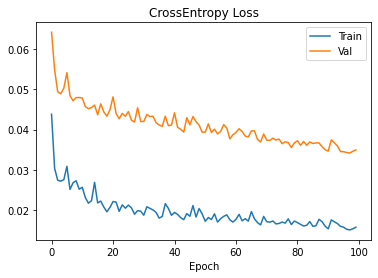

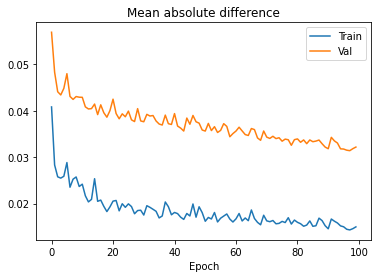

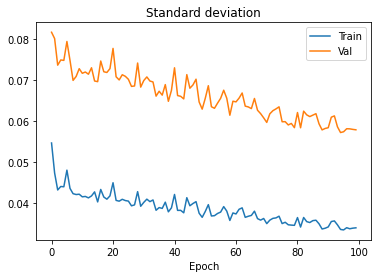

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 100
print_each = 10
n_layers = 5
n_hidden = 1200

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 2.26e-02 	Val loss: 4.47e-02
Train difference: 2.12e-02 	Val difference: 4.01e-02
Train standard deviation: 4.05e-02 	Val standard deviation: 7.00e-02

Epoch 20
Train loss: 2.09e-02 	Val loss: 4.39e-02
Train difference: 1.95e-02 	Val difference: 3.93e-02
Train standard deviation: 4.16e-02 	Val standard deviation: 7.11e-02

Epoch 30
Train loss: 1.85e-02 	Val loss: 4.02e-02
Train difference: 1.73e-02 	Val difference: 3.62e-02
Train standard deviation: 3.86e-02 	Val standard deviation: 6.71e-02

Epoch 40
Train loss: 1.89e-02 	Val loss: 4.06e-02
Train difference: 1.77e-02 	Val difference: 3.66e-02
Train standard deviation: 3.95e-02 	Val standard deviation: 6.81e-02

Epoch 50
Train loss: 1.71e-02 	Val loss: 3.71e-02
Train difference: 1.61e-02 	Val difference: 3.38e-02
Train standard deviation: 3.58e-02 	Val standard deviation: 6.15e-02

Epoch 60
Train loss: 1.61e-02 	Val loss: 3.63e-02
Train difference: 1.51e-02 	Val difference: 3.31e-02
Train standard deviation: 3.59e-

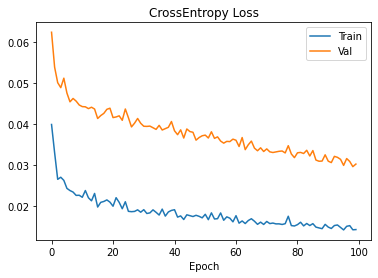

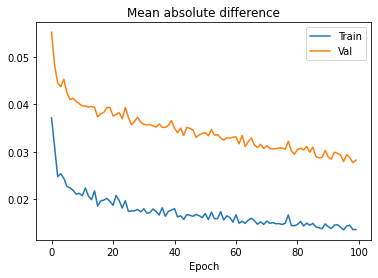

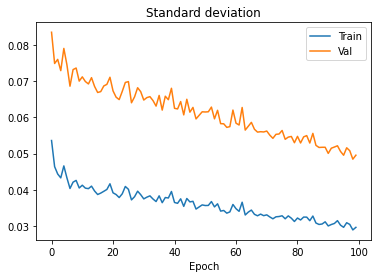

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 100
print_each = 10
n_layers = 10
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 2.70e-02 	Val loss: 5.02e-02
Train difference: 2.53e-02 	Val difference: 4.48e-02
Train standard deviation: 4.39e-02 	Val standard deviation: 7.48e-02

Epoch 20
Train loss: 2.05e-02 	Val loss: 4.28e-02
Train difference: 1.92e-02 	Val difference: 3.85e-02
Train standard deviation: 4.00e-02 	Val standard deviation: 6.88e-02

Epoch 30
Train loss: 1.91e-02 	Val loss: 4.24e-02
Train difference: 1.79e-02 	Val difference: 3.81e-02
Train standard deviation: 4.00e-02 	Val standard deviation: 6.95e-02

Epoch 40
Train loss: 2.06e-02 	Val loss: 4.18e-02
Train difference: 1.94e-02 	Val difference: 3.80e-02
Train standard deviation: 3.84e-02 	Val standard deviation: 6.49e-02

Epoch 50
Train loss: 1.76e-02 	Val loss: 3.94e-02
Train difference: 1.65e-02 	Val difference: 3.56e-02
Train standard deviation: 3.79e-02 	Val standard deviation: 6.54e-02

Epoch 60
Train loss: 1.75e-02 	Val loss: 3.75e-02
Train difference: 1.65e-02 	Val difference: 3.43e-02
Train standard deviation: 3.56e-

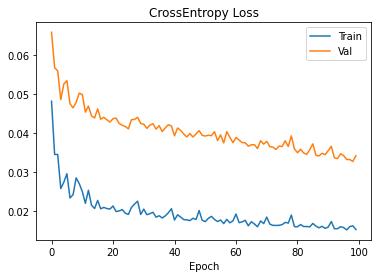

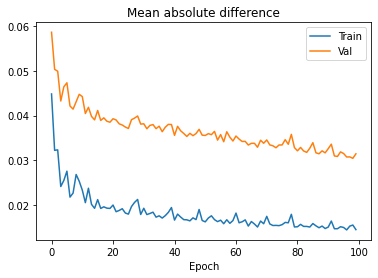

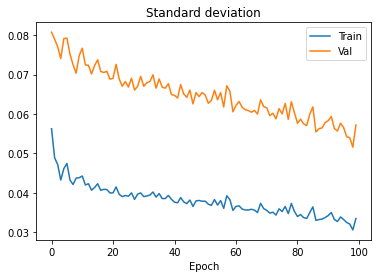

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 100
print_each = 10
n_layers = 10
n_hidden = 800

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 3.00e-02 	Val loss: 5.64e-02
Train difference: 2.78e-02 	Val difference: 4.97e-02
Train standard deviation: 4.98e-02 	Val standard deviation: 8.32e-02

Epoch 20
Train loss: 2.15e-02 	Val loss: 4.64e-02
Train difference: 1.99e-02 	Val difference: 4.11e-02
Train standard deviation: 4.35e-02 	Val standard deviation: 7.60e-02

Epoch 30
Train loss: 1.93e-02 	Val loss: 4.25e-02
Train difference: 1.80e-02 	Val difference: 3.83e-02
Train standard deviation: 3.98e-02 	Val standard deviation: 6.84e-02

Epoch 40
Train loss: 1.93e-02 	Val loss: 4.31e-02
Train difference: 1.80e-02 	Val difference: 3.88e-02
Train standard deviation: 4.04e-02 	Val standard deviation: 6.96e-02

Epoch 50
Train loss: 1.84e-02 	Val loss: 4.04e-02
Train difference: 1.72e-02 	Val difference: 3.66e-02
Train standard deviation: 3.86e-02 	Val standard deviation: 6.57e-02

Epoch 60
Train loss: 1.92e-02 	Val loss: 4.06e-02
Train difference: 1.81e-02 	Val difference: 3.68e-02
Train standard deviation: 3.77e-

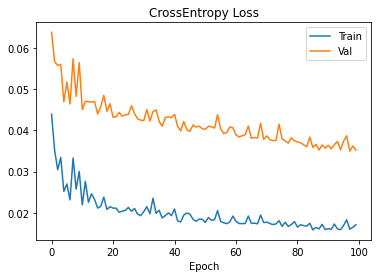

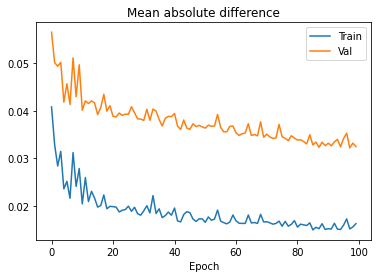

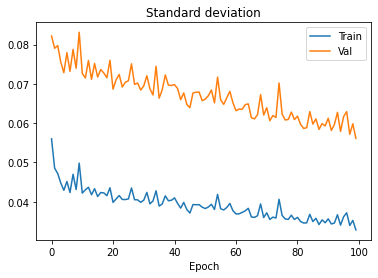

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 100
print_each = 10
n_layers = 10
n_hidden = 1200

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 2.40e-02 	Val loss: 4.48e-02
Train difference: 2.26e-02 	Val difference: 4.04e-02
Train standard deviation: 4.04e-02 	Val standard deviation: 6.84e-02

Epoch 20
Train loss: 1.99e-02 	Val loss: 4.32e-02
Train difference: 1.86e-02 	Val difference: 3.86e-02
Train standard deviation: 4.08e-02 	Val standard deviation: 7.11e-02

Epoch 30
Train loss: 1.84e-02 	Val loss: 4.06e-02
Train difference: 1.72e-02 	Val difference: 3.66e-02
Train standard deviation: 3.89e-02 	Val standard deviation: 6.73e-02

Epoch 40
Train loss: 1.79e-02 	Val loss: 3.93e-02
Train difference: 1.68e-02 	Val difference: 3.57e-02
Train standard deviation: 3.76e-02 	Val standard deviation: 6.44e-02

Epoch 50
Train loss: 1.81e-02 	Val loss: 3.90e-02
Train difference: 1.70e-02 	Val difference: 3.54e-02
Train standard deviation: 3.75e-02 	Val standard deviation: 6.44e-02

Epoch 60
Train loss: 1.77e-02 	Val loss: 3.73e-02
Train difference: 1.67e-02 	Val difference: 3.42e-02
Train standard deviation: 3.52e-

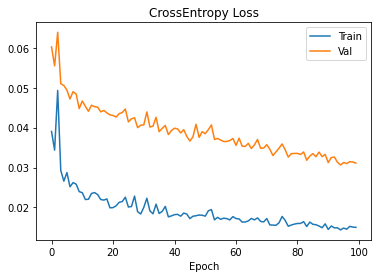

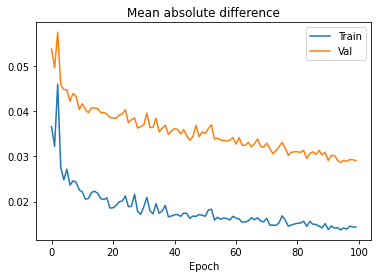

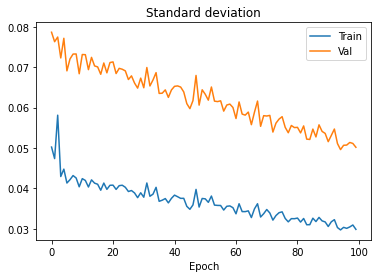

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 100
print_each = 10
n_layers = 15
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 2.32e-02 	Val loss: 4.60e-02
Train difference: 2.17e-02 	Val difference: 4.10e-02
Train standard deviation: 4.18e-02 	Val standard deviation: 7.23e-02

Epoch 20
Train loss: 2.21e-02 	Val loss: 4.63e-02
Train difference: 2.06e-02 	Val difference: 4.14e-02
Train standard deviation: 4.26e-02 	Val standard deviation: 7.34e-02

Epoch 30
Train loss: 1.94e-02 	Val loss: 4.15e-02
Train difference: 1.82e-02 	Val difference: 3.75e-02
Train standard deviation: 3.88e-02 	Val standard deviation: 6.71e-02

Epoch 40
Train loss: 2.02e-02 	Val loss: 4.23e-02
Train difference: 1.89e-02 	Val difference: 3.82e-02
Train standard deviation: 4.00e-02 	Val standard deviation: 6.80e-02

Epoch 50
Train loss: 1.85e-02 	Val loss: 4.05e-02
Train difference: 1.73e-02 	Val difference: 3.67e-02
Train standard deviation: 3.84e-02 	Val standard deviation: 6.59e-02

Epoch 60
Train loss: 1.89e-02 	Val loss: 3.96e-02
Train difference: 1.78e-02 	Val difference: 3.59e-02
Train standard deviation: 3.74e-

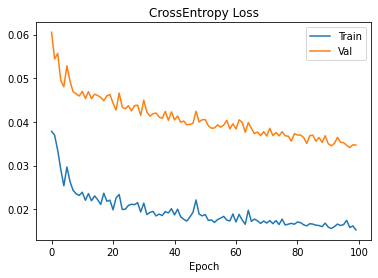

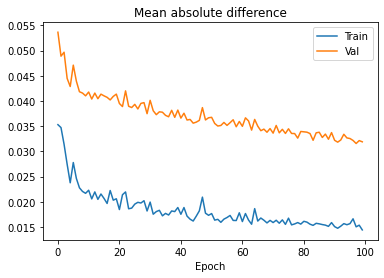

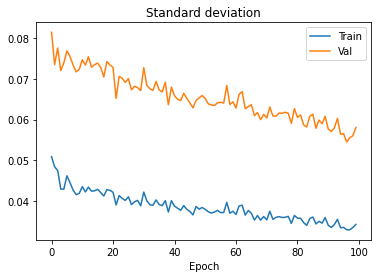

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 100
print_each = 10
n_layers = 15
n_hidden = 800

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 10
Train loss: 2.29e-02 	Val loss: 4.75e-02
Train difference: 2.13e-02 	Val difference: 4.22e-02
Train standard deviation: 4.32e-02 	Val standard deviation: 7.52e-02

Epoch 20
Train loss: 2.68e-02 	Val loss: 4.93e-02
Train difference: 2.53e-02 	Val difference: 4.45e-02
Train standard deviation: 4.08e-02 	Val standard deviation: 7.03e-02

Epoch 30
Train loss: 2.03e-02 	Val loss: 4.26e-02
Train difference: 1.90e-02 	Val difference: 3.84e-02
Train standard deviation: 3.92e-02 	Val standard deviation: 6.79e-02

Epoch 40
Train loss: 1.96e-02 	Val loss: 4.20e-02
Train difference: 1.84e-02 	Val difference: 3.80e-02
Train standard deviation: 3.87e-02 	Val standard deviation: 6.64e-02

Epoch 50
Train loss: 1.85e-02 	Val loss: 4.23e-02
Train difference: 1.72e-02 	Val difference: 3.80e-02
Train standard deviation: 4.00e-02 	Val standard deviation: 6.91e-02

Epoch 60
Train loss: 1.82e-02 	Val loss: 3.99e-02
Train difference: 1.70e-02 	Val difference: 3.62e-02
Train standard deviation: 3.82e-

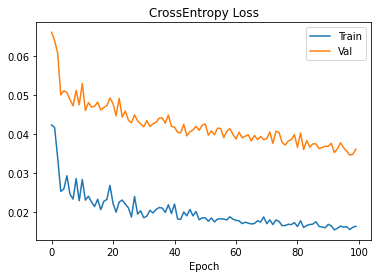

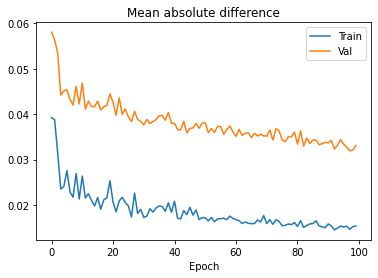

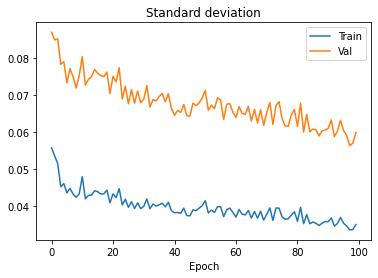

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 100
print_each = 10
n_layers = 15
n_hidden = 1200

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 50
Train loss: 1.80e-02 	Val loss: 3.87e-02
Train difference: 1.70e-02 	Val difference: 3.52e-02
Train standard deviation: 3.67e-02 	Val standard deviation: 6.29e-02

Epoch 100
Train loss: 1.52e-02 	Val loss: 3.12e-02
Train difference: 1.46e-02 	Val difference: 2.91e-02
Train standard deviation: 3.01e-02 	Val standard deviation: 5.01e-02

Epoch 150
Train loss: 1.37e-02 	Val loss: 2.81e-02
Train difference: 1.32e-02 	Val difference: 2.66e-02
Train standard deviation: 2.63e-02 	Val standard deviation: 4.34e-02

Epoch 200
Train loss: 1.21e-02 	Val loss: 2.37e-02
Train difference: 1.17e-02 	Val difference: 2.26e-02
Train standard deviation: 2.28e-02 	Val standard deviation: 3.73e-02

Epoch 250
Train loss: 1.08e-02 	Val loss: 2.19e-02
Train difference: 1.04e-02 	Val difference: 2.09e-02
Train standard deviation: 2.16e-02 	Val standard deviation: 3.56e-02

Epoch 300
Train loss: 9.69e-03 	Val loss: 1.89e-02
Train difference: 9.44e-03 	Val difference: 1.82e-02
Train standard deviation: 1

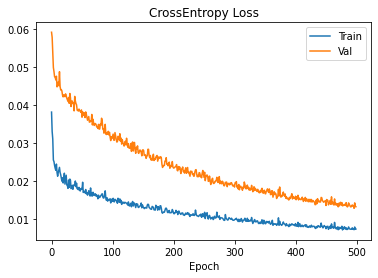

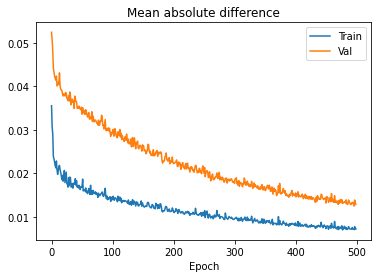

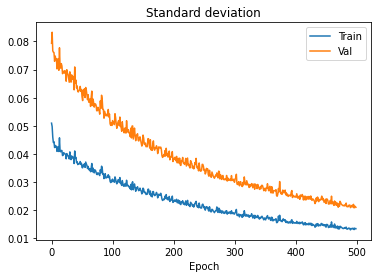

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 500
print_each = 50
n_layers = 5
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 50
Train loss: 1.80e-02 	Val loss: 3.72e-02
Train difference: 1.70e-02 	Val difference: 3.42e-02
Train standard deviation: 3.50e-02 	Val standard deviation: 5.93e-02

Epoch 100
Train loss: 1.43e-02 	Val loss: 3.02e-02
Train difference: 1.37e-02 	Val difference: 2.82e-02
Train standard deviation: 2.94e-02 	Val standard deviation: 4.90e-02

Epoch 150
Train loss: 1.22e-02 	Val loss: 2.42e-02
Train difference: 1.18e-02 	Val difference: 2.29e-02
Train standard deviation: 2.38e-02 	Val standard deviation: 3.95e-02

Epoch 200
Train loss: 1.03e-02 	Val loss: 1.95e-02
Train difference: 9.98e-03 	Val difference: 1.87e-02
Train standard deviation: 1.97e-02 	Val standard deviation: 3.21e-02

Epoch 250
Train loss: 9.78e-03 	Val loss: 1.79e-02
Train difference: 9.55e-03 	Val difference: 1.72e-02
Train standard deviation: 1.83e-02 	Val standard deviation: 2.90e-02

Epoch 300
Train loss: 9.14e-03 	Val loss: 1.59e-02
Train difference: 8.95e-03 	Val difference: 1.54e-02
Train standard deviation: 1

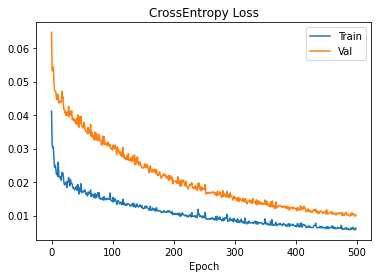

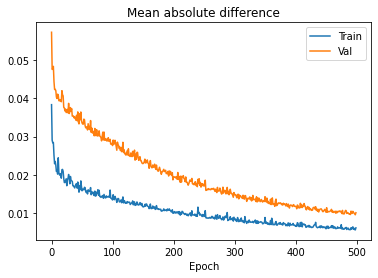

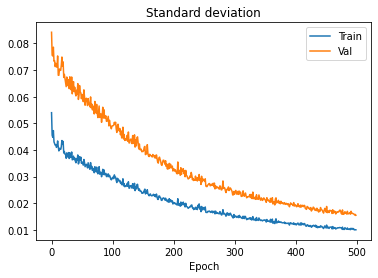

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 500
print_each = 50
n_layers = 10
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 50
Train loss: 1.74e-02 	Val loss: 3.80e-02
Train difference: 1.63e-02 	Val difference: 3.46e-02
Train standard deviation: 3.67e-02 	Val standard deviation: 6.32e-02

Epoch 100
Train loss: 1.52e-02 	Val loss: 3.10e-02
Train difference: 1.45e-02 	Val difference: 2.89e-02
Train standard deviation: 3.06e-02 	Val standard deviation: 5.12e-02

Epoch 150
Train loss: 1.20e-02 	Val loss: 2.50e-02
Train difference: 1.16e-02 	Val difference: 2.36e-02
Train standard deviation: 2.51e-02 	Val standard deviation: 4.15e-02

Epoch 200
Train loss: 1.15e-02 	Val loss: 2.28e-02
Train difference: 1.11e-02 	Val difference: 2.17e-02
Train standard deviation: 2.24e-02 	Val standard deviation: 3.66e-02

Epoch 250
Train loss: 9.35e-03 	Val loss: 1.77e-02
Train difference: 9.13e-03 	Val difference: 1.71e-02
Train standard deviation: 1.79e-02 	Val standard deviation: 2.83e-02

Epoch 300
Train loss: 8.22e-03 	Val loss: 1.48e-02
Train difference: 8.06e-03 	Val difference: 1.44e-02
Train standard deviation: 1

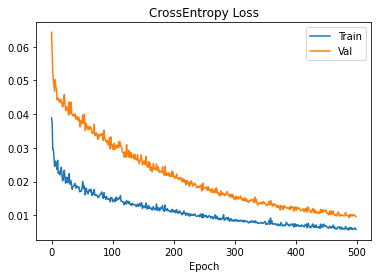

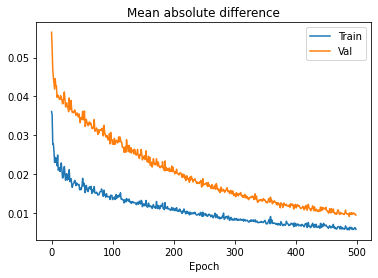

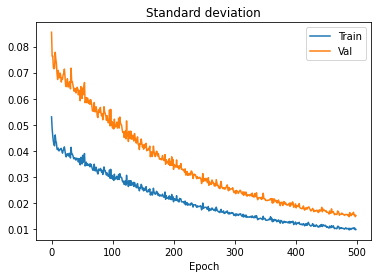

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 500
print_each = 50
n_layers = 15
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")

Epoch 50
Train loss: 1.70e-02 	Val loss: 3.73e-02
Train difference: 1.59e-02 	Val difference: 3.40e-02
Train standard deviation: 3.62e-02 	Val standard deviation: 6.25e-02

Epoch 100
Train loss: 1.46e-02 	Val loss: 3.15e-02
Train difference: 1.39e-02 	Val difference: 2.94e-02
Train standard deviation: 3.08e-02 	Val standard deviation: 5.17e-02

Epoch 150
Train loss: 1.27e-02 	Val loss: 2.52e-02
Train difference: 1.23e-02 	Val difference: 2.40e-02
Train standard deviation: 2.49e-02 	Val standard deviation: 4.04e-02

Epoch 200
Train loss: 1.05e-02 	Val loss: 2.07e-02
Train difference: 1.02e-02 	Val difference: 1.98e-02
Train standard deviation: 2.06e-02 	Val standard deviation: 3.35e-02

Epoch 250
Train loss: 1.12e-02 	Val loss: 1.89e-02
Train difference: 1.09e-02 	Val difference: 1.83e-02
Train standard deviation: 1.83e-02 	Val standard deviation: 2.85e-02

Epoch 300
Train loss: 8.25e-03 	Val loss: 1.50e-02
Train difference: 8.08e-03 	Val difference: 1.45e-02
Train standard deviation: 1

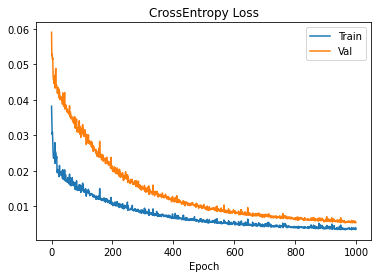

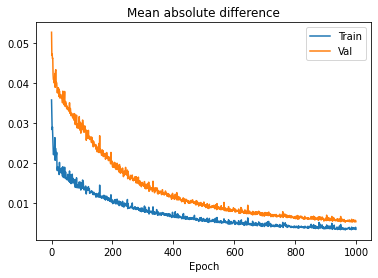

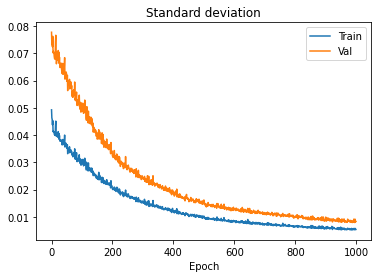

In [ ]:
%%time

batch_size = 200
input_size = X_train.shape[1]
lr = 1e-4
epochs = 1000
print_each = 50
n_layers = 15
n_hidden = 400

model = MLP(input_size, n_layers, n_hidden)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_model, logger, best_diff, best_std = train(model, data_loader_train, data_loader_test, optimizer, epochs,
              print_each=print_each)

logger.plot_loss()
logger.plot_difference()
logger.plot_standard_deviation()

print(f"Différence absolue moyenne sur le meilleur modèle avec les données de validation : {best_diff:.2e}")
print(f"Écart type associé au meilleur modèle avec les données de validation : {best_std:.2e}")